In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
import scipy.io as sio
#import keras 

In [3]:
from __future__ import print_function
import time

from functools import reduce
import math as m

from scipy.interpolate import griddata
from sklearn.preprocessing import scale
from dreamUtils import *


np.random.seed(1234)

In [4]:
def normalize_among_channels(x):
    """
     Normalizes the values of each electrodes relatively to each other.Normalizes the value for each time stemp    
    :param x: trail to be normalized
    :return: normalized trail for each row
    """
    mean_time = np.expand_dims(x.mean(axis=1),axis=1)
    std_time = np.expand_dims(x.std(axis=1), axis=1)
    return (x-mean_time)/std_time

In [5]:
def normalize_through_time(x):
    """
    Normalized the value for each electrode throuhout the trail time 
    
    :param x: trail to be normalized
    :return: normalized trail for each column
    """
    mean_channel = np.expand_dims(x.mean(axis=0),axis=0)
    std_channel = np.expand_dims(x.std(axis=0), axis=0)
    std_channel[0,x.shape[1]-1]=1
    return (x-mean_channel)/std_channel

In [6]:
def map_to_2d(locs_3D):
    """
    Maps the 3D positions of the electrodes into 2D plane with AEP algorithm 
    
    :param locs_3D: matrix of shape number_of_electrodes x 3, for X,Y,Z coordinates respectively
    :return: matrix of shape number_of_electrodes x 2
    """
    locs_2D = []
    for e in locs_3D:
        locs_2D.append(azim_proj(e))
    
    return np.array(locs_2D)

In [7]:
locs_3D = sio.loadmat('./data/channelcoords.mat')['locstemp']

In [57]:
trial = (sio.loadmat('./data/JL02trial_24.mat')['a_trial']).T

In [58]:
trial.shape
trial[:, 256]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

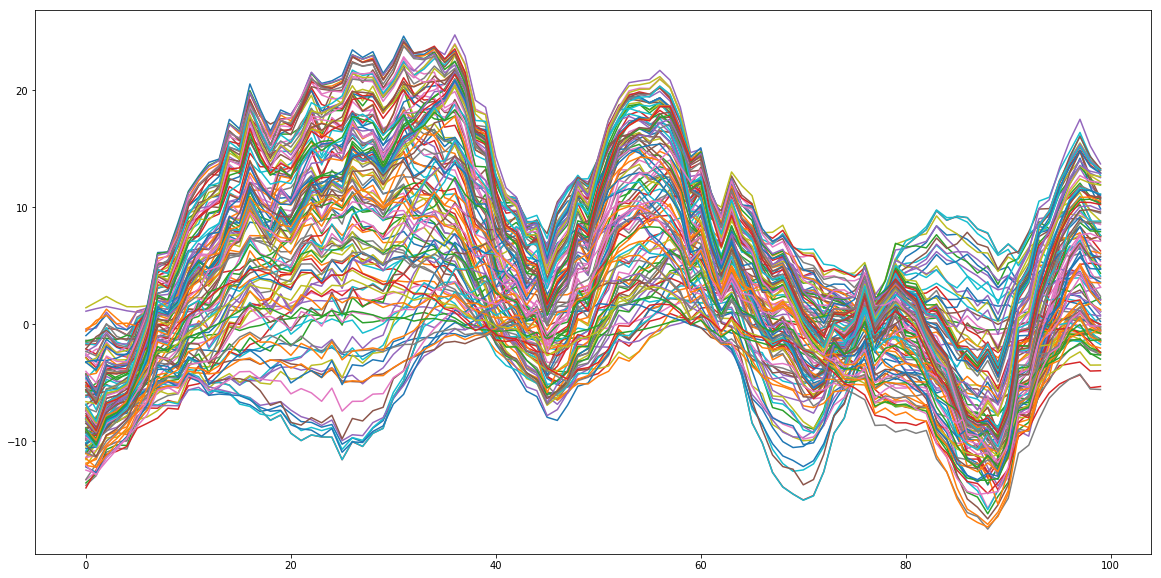

In [9]:
plt.figure(figsize=(20,10))
sl = range(0,1000,10)

for i in range(0,256, 2):
    plt.plot(trial[-100:,i])

plt.show()

In [10]:
"""
Number of time stamp =  shape[0] with sampling 500Hz roughly 2 minutes
"""
print('Number of time step=', trial.shape[0], ' with sampling 500Hz roughly ', trial.shape[0]/500/60, \
      ' minutes recoridng of a single trial')

Number of time step= 60003  with sampling 500Hz roughly  2.0001  minutes recoridng of a single trial


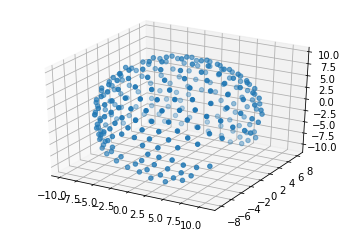

In [11]:
#Show 3D locations of 256 electrodes 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(locs_3D[:,0], locs_3D[:,1], locs_3D[:,2])

<IPython.core.display.Javascript object>


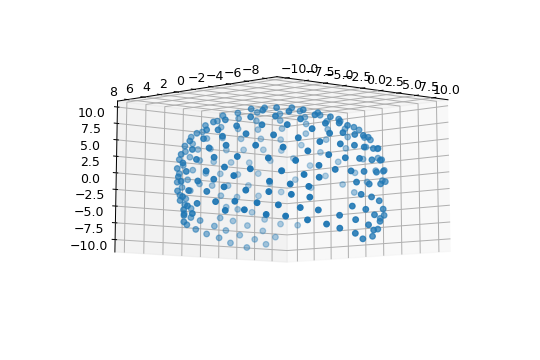

In [14]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(locs_3D[:,0], locs_3D[:,1], locs_3D[:,2])

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

In [15]:
locs_2D = map_to_2d(locs_3D)
trial.shape

(60003, 257)

In [16]:
trial_20 = trial[-10000:,:] #last 20 second

In [17]:
def gen_images(locs, features, n_gridpoints, normalize=False,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    #assert features.shape[1] % nElectrodes == 0
    n_colors = int(features.shape[1] / nElectrodes)
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1) 

In [18]:
images = gen_images(locs_2D, trial_20[:100,:] , 32, normalize=False,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False)

Interpolating 100/100

In [19]:
images.shape

(100, 1, 32, 32)

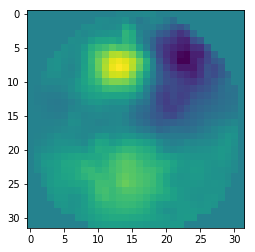

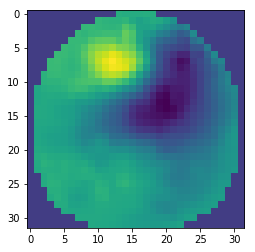

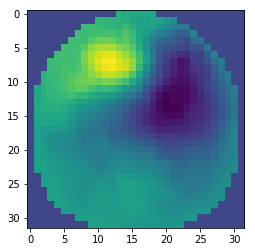

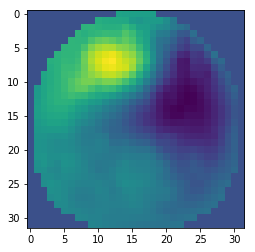

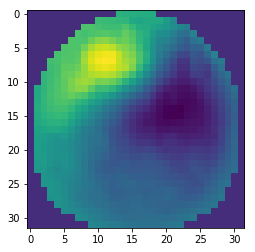

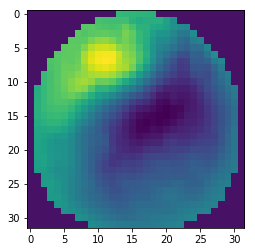

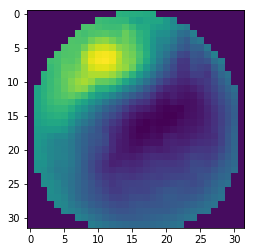

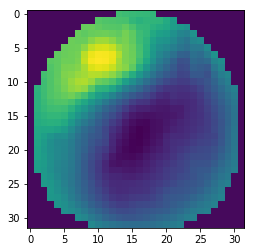

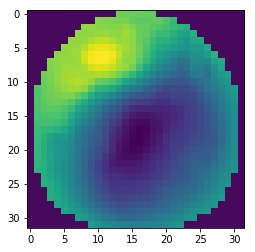

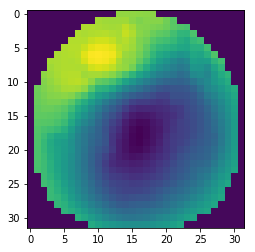

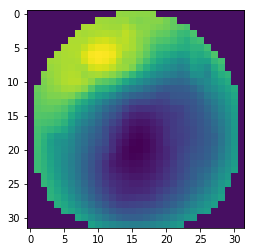

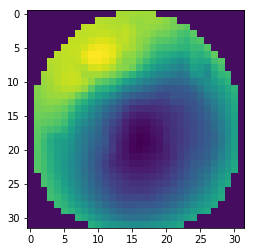

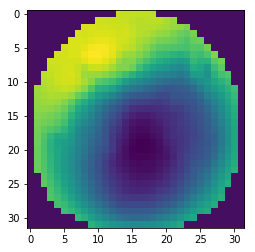

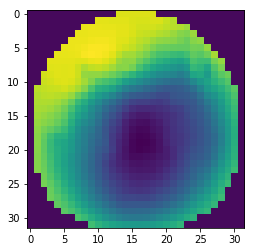

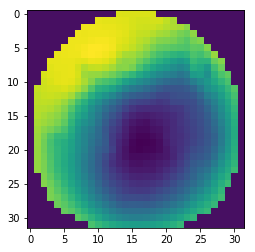

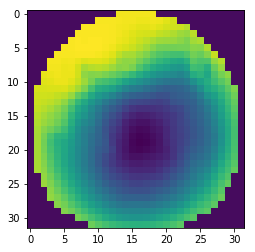

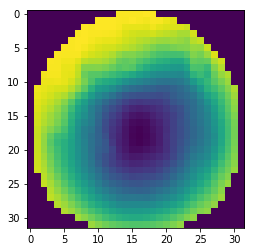

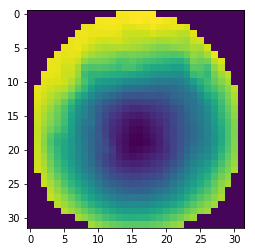

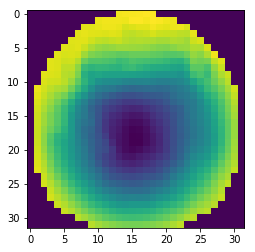

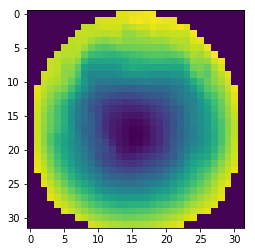

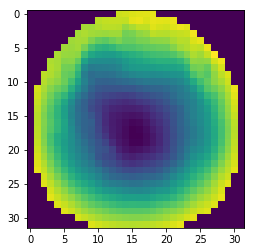

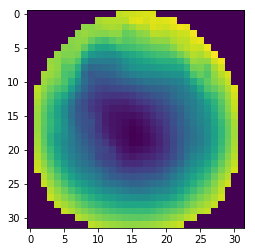

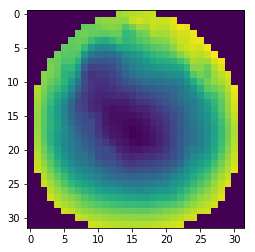

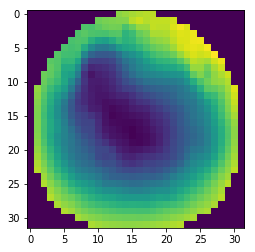

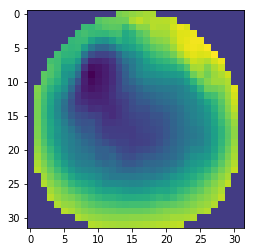

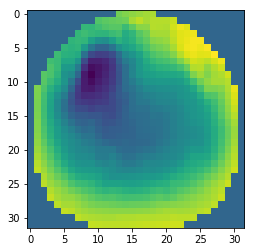

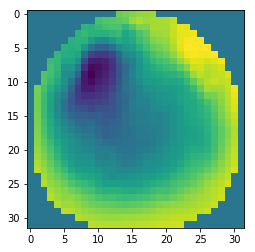

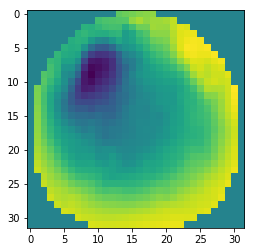

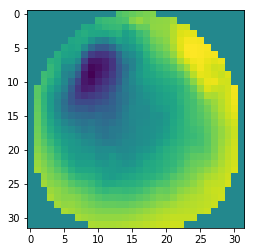

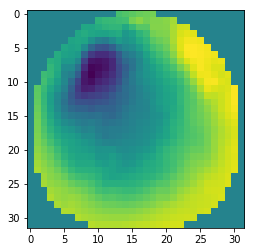

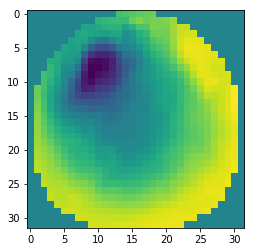

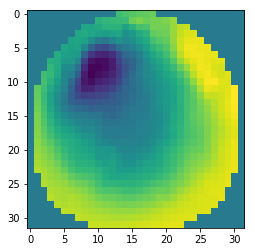

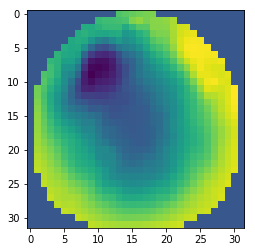

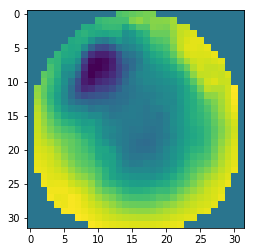

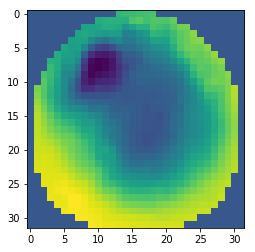

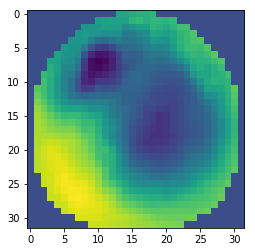

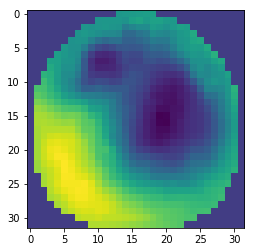

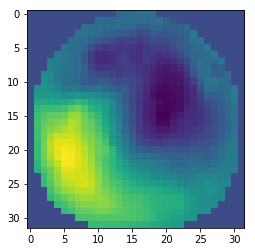

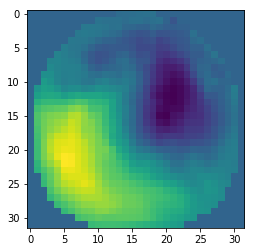

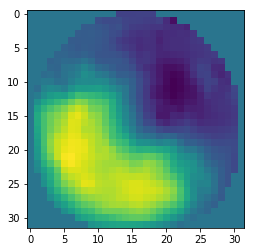

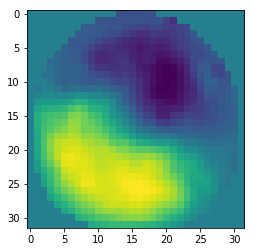

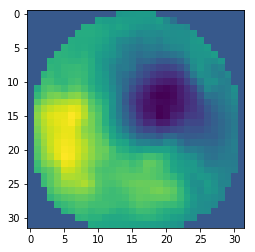

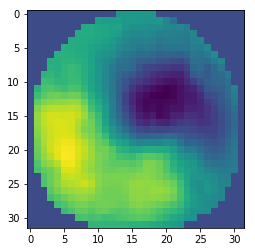

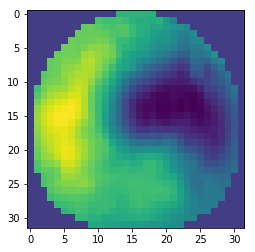

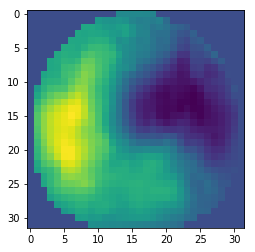

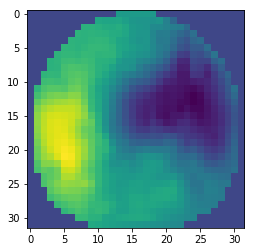

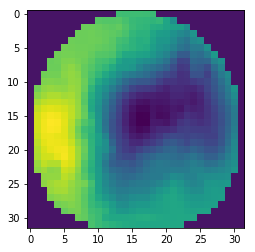

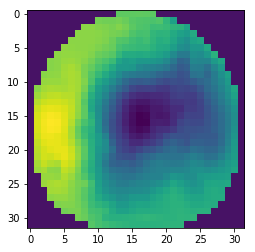

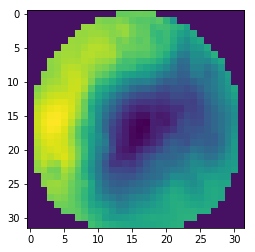

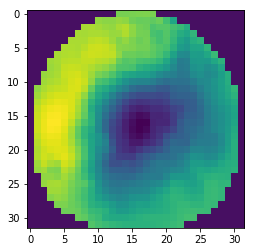

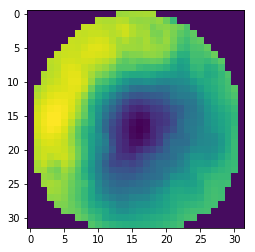

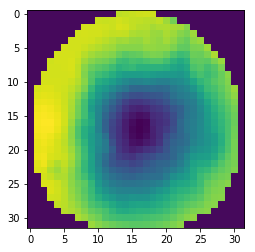

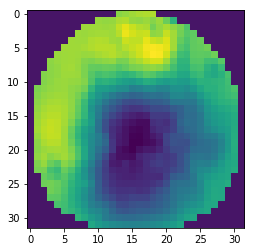

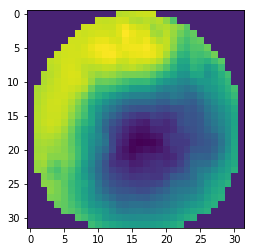

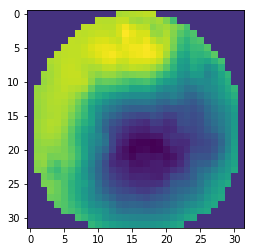

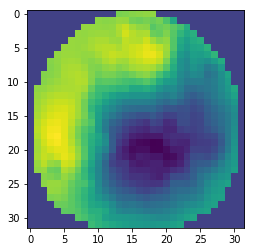

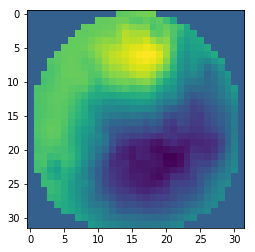

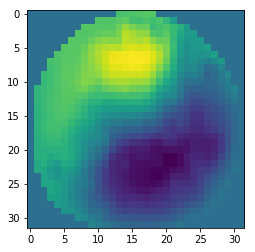

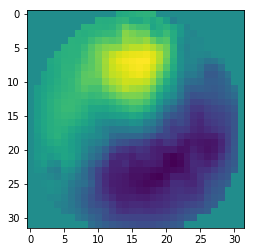

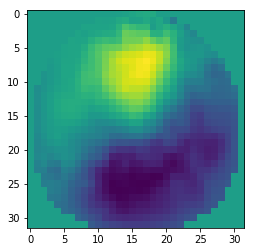

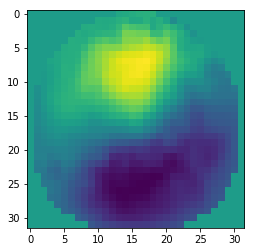

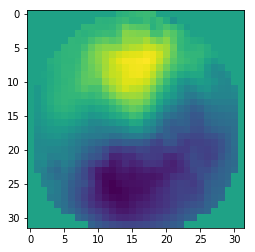

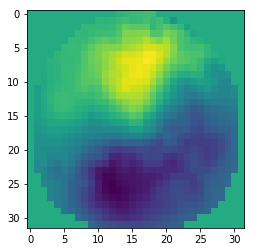

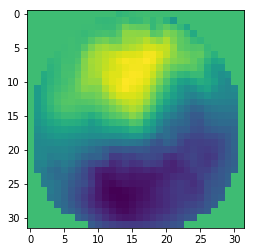

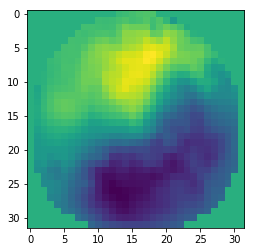

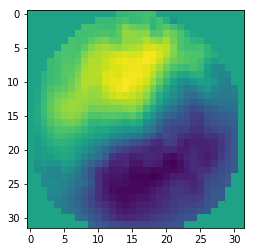

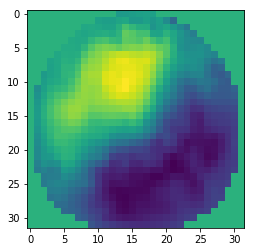

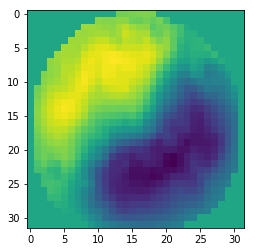

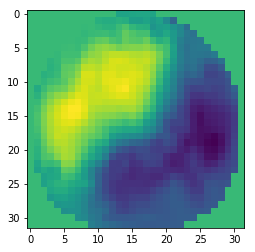

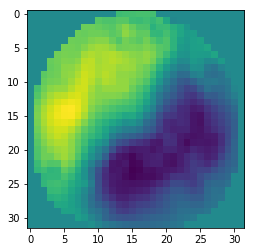

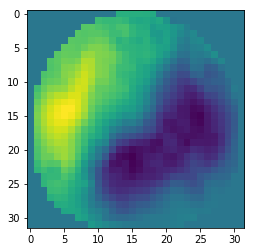

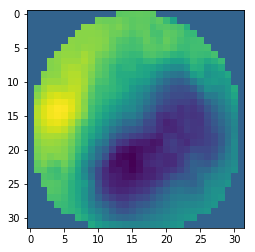

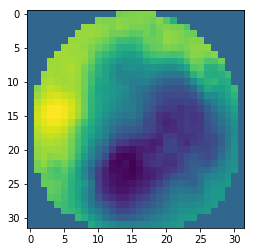

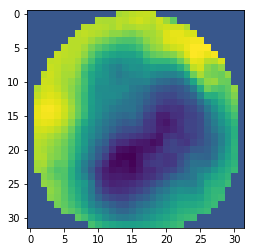

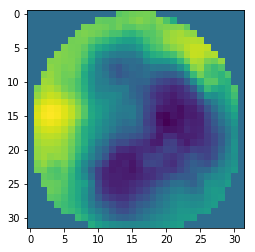

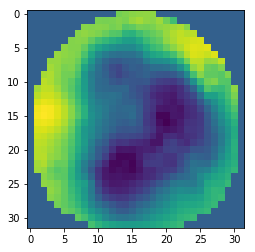

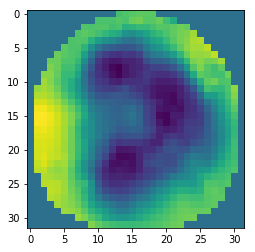

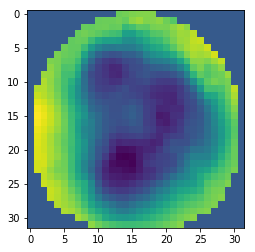

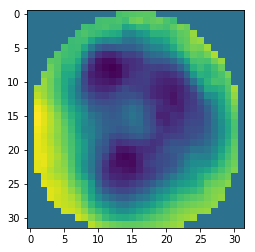

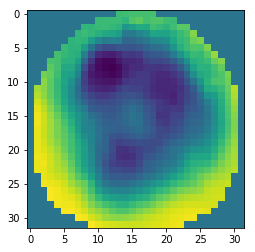

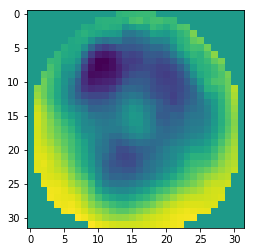

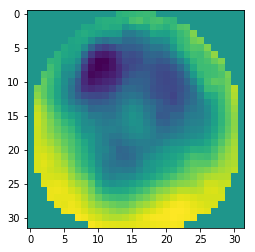

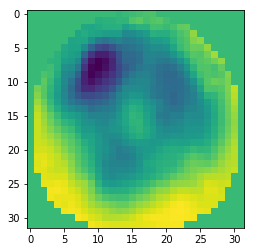

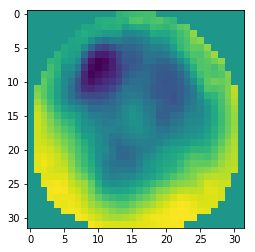

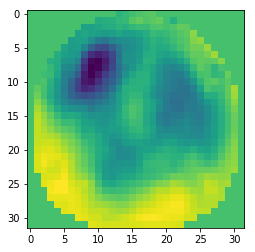

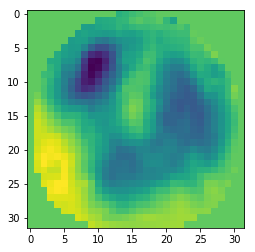

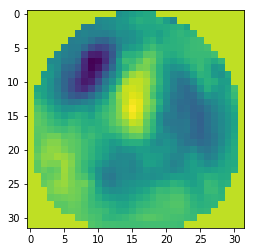

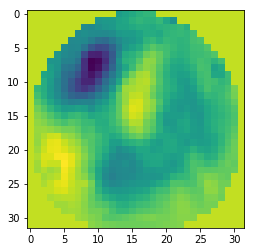

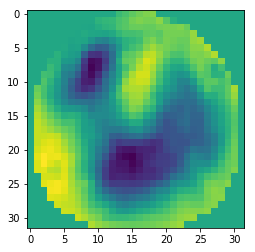

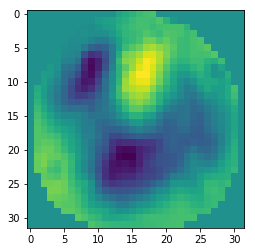

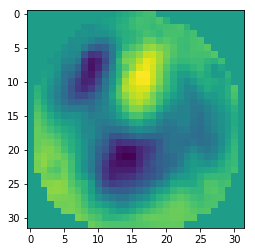

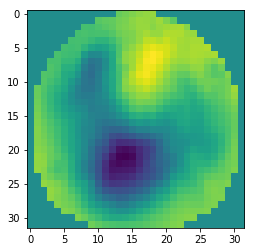

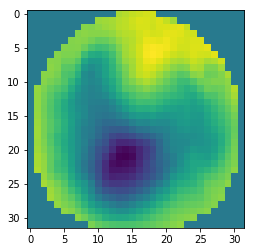

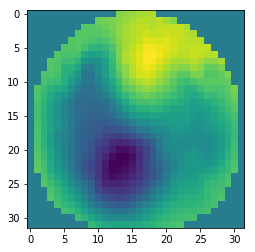

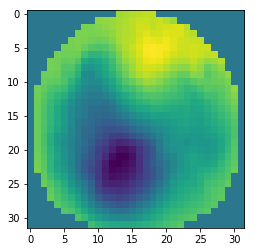

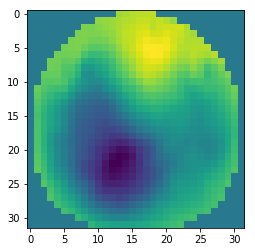

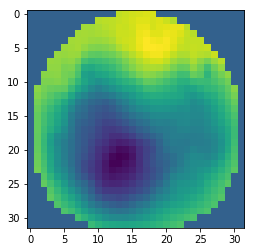

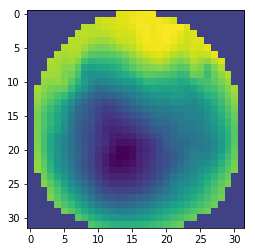

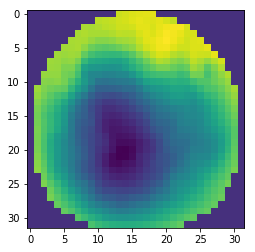

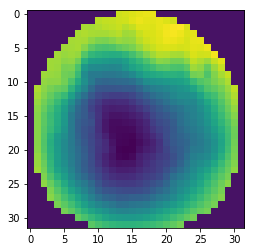

In [26]:
%matplotlib inline

for i in range(images.shape[0]):
    img1 = images[i][0]
    plt.imshow(img1)
    plt.show()